In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Flatten, Dropout, Dense, Reshape, Bidirectional
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the text documents

data = pd.read_csv("out/Data.csv")
X = data.iloc[:, :-1]
y = data['AttackOrNot']


smote = SMOTE(sampling_strategy='auto')
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=100)



print(X_resampled.shape)
print(y_resampled.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:

# Calculate Pearson correlation coefficients between features and target variable
correlations = np.abs(np.corrcoef(X_resampled, y_resampled, rowvar=False)[:-1, -1])

# Set a correlation threshold (you can adjust this value)
correlation_threshold = 0.1

# Select features with absolute correlation above the threshold
selected_features = X.columns[correlations > correlation_threshold]

# Subset the resampled dataset with the selected features
X_resampled_selected = X_resampled[selected_features]

# Split the resampled data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_selected, y_resampled, test_size=0.3, random_state=100)


print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
selected_features

In [73]:
input_shape = (X_train.shape[1], 1)  # Assuming time series data with 1 feature

# Build the CNN model
model = Sequential()

# Reshape the data
model.add(Reshape((X_train.shape[1], 1), input_shape=input_shape))

# Second convolutional layer
model.add(Conv1D(64, kernel_size=4, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(tf.keras.layers.BatchNormalization())

# Third convolutional layer
model.add(Conv1D(128, kernel_size=4, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(tf.keras.layers.BatchNormalization())


# Flatten layer
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(tf.keras.layers.BatchNormalization())

# Output layer
model.add(Dense(1, activation='sigmoid'))


model.summary()
start_time = time.time()

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Record the end time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time
training_time = training_time * 1e6

# Print the training time
print(f"Elapsed time: {training_time:.2f} microseconds")
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Make predictions on the test set
predictions = model.predict(X_test)

# # Print the accuracy of the model
print('Test accuracy:', test_accuracy)


y_pred = (model.predict(X_test) > 0.5).astype("int32")
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(conf_matrix)
print('\nClassification Report:')
print(classification_rep)


Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_10 (Reshape)        (None, 19, 1)             0         
                                                                 
 conv1d_72 (Conv1D)          (None, 19, 64)            320       
                                                                 
 max_pooling1d_53 (MaxPooli  (None, 9, 64)             0         
 ng1D)                                                           
                                                                 
 batch_normalization_12 (Ba  (None, 9, 64)             256       
 tchNormalization)                                               
                                                                 
 conv1d_73 (Conv1D)          (None, 9, 128)            32896     
                                                                 
 max_pooling1d_54 (MaxPooli  (None, 4, 128)          

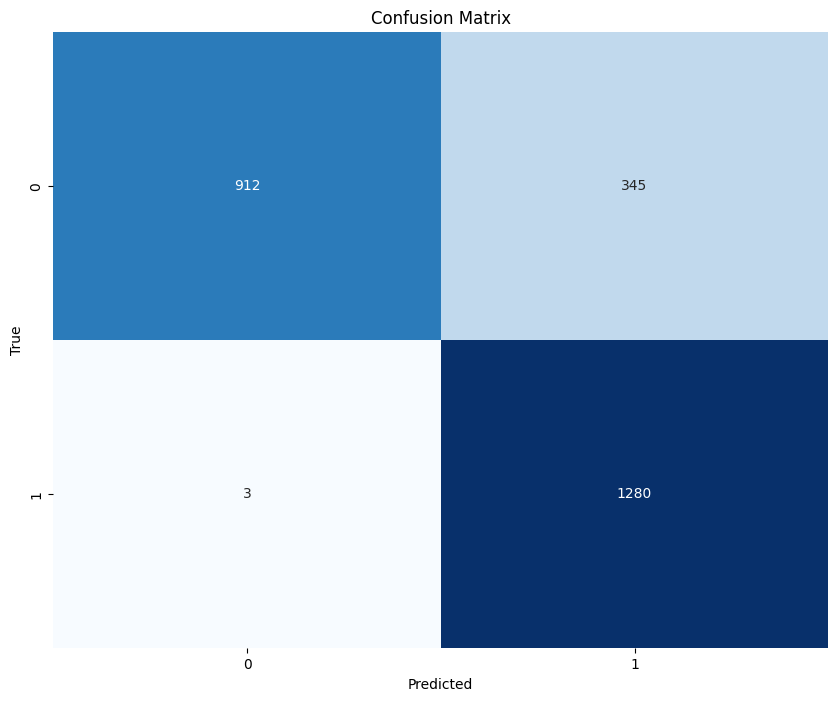

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc,recall_score, roc_auc_score, precision_recall_curve, average_precision_score, precision_score, accuracy_score, f1_score
# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

80/80 [==============================] - 0s 2ms/step
Precision: 78.77%
Accuracy: 86.30%
F1 Score: 88.03%
Recall: 99.77%


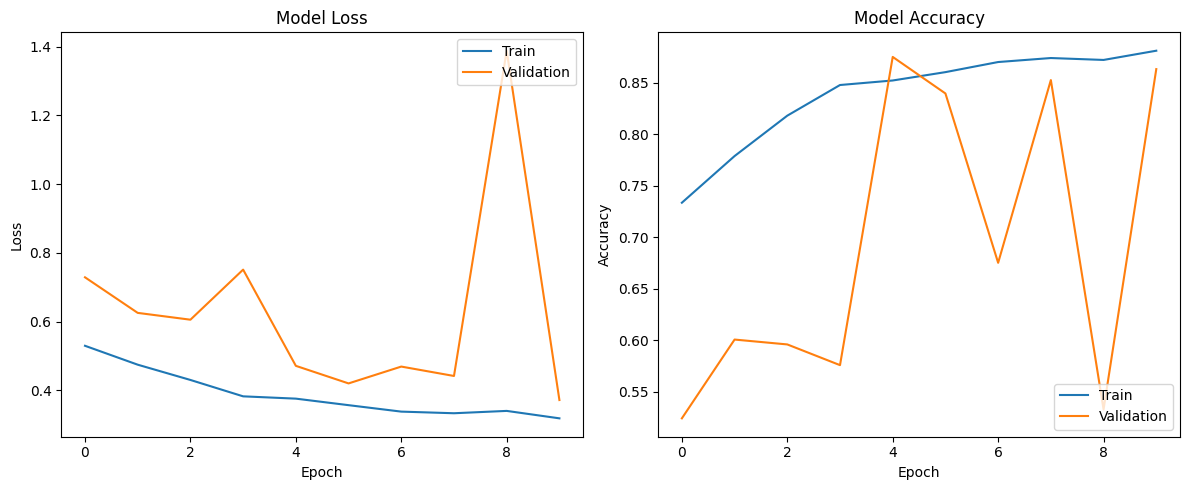

In [75]:
y_pred_proba = model.predict(X_test)


# Calculate evaluation metrics
precision = precision_score(y_test, y_pred) * 100
accuracy = accuracy_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100

# Print the metrics
print("Precision: {:.2f}%".format(precision))
print("Accuracy: {:.2f}%".format(accuracy))
print("F1 Score: {:.2f}%".format(f1))
print("Recall: {:.2f}%".format(recall))




# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

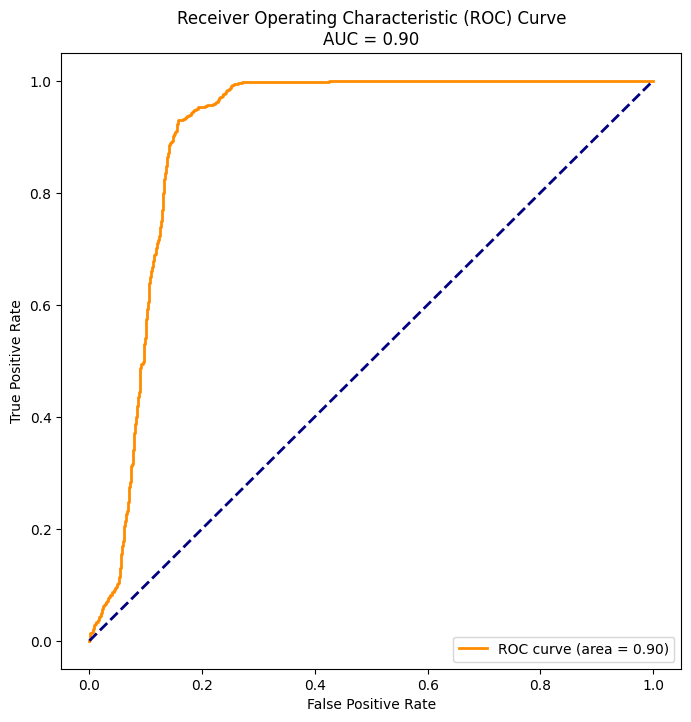

In [76]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve with AUC value
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nAUC = {:.2f}'.format(roc_auc))
plt.legend(loc='lower right')
plt.show()

